# Audit Results Analysis

Comprehensive analysis of SAM3 boundary adherence and mask quality metrics. This notebook analyzes audit results from different inference strategies (baseline, multi_crop, tiled) and prompt levels (L1-L4).

**Features:**
- Dynamically loads all audit results CSV files from the results directory
- Compares boundary adherence, IoU, and Dice metrics across strategies
- Generates statistical summaries and visualizations
- Extensible design to automatically incorporate new audit results


In [32]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import json
from typing import Dict, List, Tuple, Optional
from collections import defaultdict

warnings.filterwarnings('ignore')

# Set style for visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configure paths
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent
AUDIT_RESULTS_DIR = PROJECT_ROOT / "outputs" / "audit_results"
DATA_ROOT = PROJECT_ROOT / "data" / "cityscapes"

print(f"✓ Project root: {PROJECT_ROOT}")
print(f"✓ Audit results directory: {AUDIT_RESULTS_DIR}")
print(f"✓ Audit results exist: {AUDIT_RESULTS_DIR.exists()}")

✓ Project root: /home/griffing52/programming/research/urban-segmentation
✓ Audit results directory: /home/griffing52/programming/research/urban-segmentation/outputs/audit_results
✓ Audit results exist: True


## 1. Define Flexible Data Loading Functions

Functions to dynamically discover and load audit results, handling various strategies and prompt levels.


In [33]:
def discover_audit_results(results_dir: Path) -> Dict[str, Path]:
    """
    Discover all audit result CSV files in the results directory.
    
    Args:
        results_dir: Path to audit_results directory
        
    Returns:
        Dictionary mapping strategy names to CSV file paths
    """
    csv_files = {}
    
    if not results_dir.exists():
        print(f"⚠ Audit results directory not found: {results_dir}")
        return csv_files
    
    for csv_file in sorted(results_dir.glob("*_results.csv")):
        # Extract strategy name from filename
        # Format: sam3_{method}_{prompt_level}[_{params}]_results.csv
        strategy_name = csv_file.stem.replace("_results", "")
        csv_files[strategy_name] = csv_file
    
    return csv_files


def load_audit_results(results_dir: Path) -> pd.DataFrame:
    """
    Load all audit results from CSV files into a single DataFrame.
    
    Dynamically discovers and loads all available audit results,
    adding a 'strategy' column to identify the source.
    
    Args:
        results_dir: Path to audit_results directory
        
    Returns:
        Combined DataFrame with all audit results
    """
    csv_files = discover_audit_results(results_dir)
    
    if not csv_files:
        print("⚠ No audit results found")
        return pd.DataFrame()
    
    dfs = []
    for strategy_name, csv_path in csv_files.items():
        try:
            df = pd.read_csv(csv_path)
            df['strategy'] = strategy_name
            dfs.append(df)
            print(f"✓ Loaded {len(df)} results from {strategy_name}")
        except Exception as e:
            print(f"✗ Error loading {csv_path}: {e}")
    
    if dfs:
        combined_df = pd.concat(dfs, ignore_index=True)
        return combined_df
    else:
        return pd.DataFrame()


def parse_strategy_components(strategy_name: str) -> Dict[str, str]:
    """
    Parse strategy name into components.
    
    Examples:
        'sam3_baseline_L1_Baseline' -> {'method': 'baseline', 'prompt': 'L1_Baseline', 'params': ''}
        'sam3_tiled_L2_Descriptive_window_size=1024_stride=512' -> 
            {'method': 'tiled', 'prompt': 'L2_Descriptive', 'params': 'window_size=1024_stride=512'}
    
    Args:
        strategy_name: Strategy name from CSV filename
        
    Returns:
        Dictionary with 'method', 'prompt_level', and 'params' keys
    """
    # Remove 'sam3_' prefix
    name = strategy_name.replace('sam3_', '')
    
    parts = name.split('_')
    
    # Extract method (baseline, multi_crop, tiled)
    method = parts[0] if parts else 'unknown'
    
    # Extract prompt level (L1, L2, L3, L4 + descriptor)
    prompt_level = ''
    params = ''
    
    if len(parts) > 1:
        # Check if next parts are prompt level
        for i in range(1, min(4, len(parts))):
            if parts[i].startswith('L') and parts[i][1].isdigit():
                prompt_level = '_'.join(parts[1:i+2])
                params = '_'.join(parts[i+2:])
                break
    
    return {
        'method': method,
        'prompt_level': prompt_level,
        'params': params
    }


# Discover available audit results
audit_csv_files = discover_audit_results(AUDIT_RESULTS_DIR)
print(f"\nFound {len(audit_csv_files)} audit result file(s):")
for strategy in sorted(audit_csv_files.keys()):
    print(f"  - {strategy}")


Found 17 audit result file(s):
  - audit_combined
  - sam3_baseline_L1_Baseline
  - sam3_baseline_L2_Descriptive
  - sam3_baseline_L3_Physical
  - sam3_baseline_L4_Specific
  - sam3_multi_crop_L1_Baseline_grid_size=(2, 2)
  - sam3_multi_crop_L2_Descriptive_grid_size=(2, 2)
  - sam3_multi_crop_L3_Physical_grid_size=(2, 2)
  - sam3_multi_crop_L4_Specific_grid_size=(2, 2)
  - sam3_tiled_L1_Baseline_window_size=1024_stride=256
  - sam3_tiled_L1_Baseline_window_size=1024_stride=512
  - sam3_tiled_L2_Descriptive_window_size=1024_stride=256
  - sam3_tiled_L2_Descriptive_window_size=1024_stride=512
  - sam3_tiled_L3_Physical_window_size=1024_stride=256
  - sam3_tiled_L3_Physical_window_size=1024_stride=512
  - sam3_tiled_L4_Specific_window_size=1024_stride=256
  - sam3_tiled_L4_Specific_window_size=1024_stride=512


## 2. Aggregate Audit Results

Load and combine all audit results into unified DataFrames with strategy components parsed.


In [34]:
# Load all audit results
df_all = load_audit_results(AUDIT_RESULTS_DIR)

if df_all.empty:
    print("⚠ No audit results to analyze. Run auditor first.")
else:
    print(f"\n✓ Total records loaded: {len(df_all)}")
    print(f"✓ Number of strategies: {df_all['strategy'].nunique()}")
    print(f"✓ Columns: {list(df_all.columns)}\n")
    
    # Parse strategy components
    df_all['method'] = df_all['strategy'].apply(lambda x: parse_strategy_components(x)['method'])
    df_all['prompt_level'] = df_all['strategy'].apply(lambda x: parse_strategy_components(x)['prompt_level'])
    
    # Display first few rows
    print("Sample data:")
    display(df_all.head())

✓ Loaded 100 results from audit_combined
✓ Loaded 50 results from sam3_baseline_L1_Baseline
✓ Loaded 50 results from sam3_baseline_L2_Descriptive
✓ Loaded 50 results from sam3_baseline_L3_Physical
✓ Loaded 50 results from sam3_baseline_L4_Specific
✓ Loaded 50 results from sam3_multi_crop_L1_Baseline_grid_size=(2, 2)
✓ Loaded 50 results from sam3_multi_crop_L2_Descriptive_grid_size=(2, 2)
✓ Loaded 50 results from sam3_multi_crop_L3_Physical_grid_size=(2, 2)
✓ Loaded 50 results from sam3_multi_crop_L4_Specific_grid_size=(2, 2)
✓ Loaded 50 results from sam3_tiled_L1_Baseline_window_size=1024_stride=256
✓ Loaded 50 results from sam3_tiled_L1_Baseline_window_size=1024_stride=512
✓ Loaded 50 results from sam3_tiled_L2_Descriptive_window_size=1024_stride=256
✓ Loaded 50 results from sam3_tiled_L2_Descriptive_window_size=1024_stride=512
✓ Loaded 50 results from sam3_tiled_L3_Physical_window_size=1024_stride=256
✓ Loaded 50 results from sam3_tiled_L3_Physical_window_size=1024_stride=512
✓ Loade

,image_id,class_id,boundary_score_human,boundary_score_sam,iou,dice,human_area,sam_area,strategy,method,prompt_level
0,frankfurt_000000_000294,17,69.614519,72.535237,0.822598,0.902665,24870,20458,audit_combined,audit,
1,frankfurt_000000_000576,17,77.510696,80.385112,0.701054,0.824258,11196,7849,audit_combined,audit,
2,frankfurt_000000_001016,17,91.795926,96.396631,0.862483,0.926164,10086,8699,audit_combined,audit,
3,frankfurt_000000_001236,17,51.967825,53.298658,0.786495,0.880489,23428,18426,audit_combined,audit,
4,frankfurt_000000_001751,17,53.045658,57.672899,0.644882,0.784107,13404,8644,audit_combined,audit,


## 3. Generate Summary Statistics

Calculate key metrics across all strategies and samples.


In [35]:
if not df_all.empty:
    # Overall statistics
    print("=" * 80)
    print("OVERALL STATISTICS")
    print("=" * 80)
    
    overall_stats = {
        'Total Samples': len(df_all),
        'Unique Strategies': df_all['strategy'].nunique(),
        'Unique Methods': df_all['method'].nunique(),
        'Unique Prompt Levels': df_all['prompt_level'].nunique(),
    }
    
    for key, value in overall_stats.items():
        print(f"{key:<25} {value}")
    
    # Boundary adherence statistics
    print("\n" + "=" * 80)
    print("BOUNDARY ADHERENCE METRICS")
    print("=" * 80)
    
    boundary_metrics = {
        'Human Mean': df_all['boundary_score_human'].mean(),
        'Human Std': df_all['boundary_score_human'].std(),
        'SAM Mean': df_all['boundary_score_sam'].mean(),
        'SAM Std': df_all['boundary_score_sam'].std(),
        'Difference (SAM - Human)': (df_all['boundary_score_sam'] - df_all['boundary_score_human']).mean(),
    }
    
    for metric, value in boundary_metrics.items():
        print(f"{metric:<30} {value:.4f}")
    
    # Overlap metrics
    print("\n" + "=" * 80)
    print("OVERLAP METRICS (IoU & Dice)")
    print("=" * 80)
    
    overlap_metrics = {
        'IoU Mean': df_all['iou'].mean(),
        'IoU Std': df_all['iou'].std(),
        'IoU Min': df_all['iou'].min(),
        'IoU Max': df_all['iou'].max(),
        'Dice Mean': df_all['dice'].mean(),
        'Dice Std': df_all['dice'].std(),
        'Dice Min': df_all['dice'].min(),
        'Dice Max': df_all['dice'].max(),
    }
    
    for metric, value in overlap_metrics.items():
        print(f"{metric:<30} {value:.4f}")
    
    # Strategy-level statistics
    print("\n" + "=" * 80)
    print("STATISTICS BY STRATEGY")
    print("=" * 80)
    
    strategy_stats = df_all.groupby('strategy').agg({
        'image_id': 'count',
        'boundary_score_human': ['mean', 'std'],
        'boundary_score_sam': ['mean', 'std'],
        'iou': ['mean', 'std'],
        'dice': ['mean', 'std'],
    }).round(4)
    
    strategy_stats.columns = ['_'.join(col).strip() for col in strategy_stats.columns.values]
    strategy_stats = strategy_stats.rename(columns={'image_id_count': 'n_samples'})
    
    print(strategy_stats)
else:
    print("⚠ No data to analyze")

OVERALL STATISTICS
Total Samples             900
Unique Strategies         17
Unique Methods            4
Unique Prompt Levels      9

BOUNDARY ADHERENCE METRICS
Human Mean                     78.0328
Human Std                      17.5639
SAM Mean                       80.7268
SAM Std                        18.2965
Difference (SAM - Human)       2.6940

OVERLAP METRICS (IoU & Dice)
IoU Mean                       0.8227
IoU Std                        0.0517
IoU Min                        0.6449
IoU Max                        0.9009
Dice Mean                      0.9018
Dice Std                       0.0321
Dice Min                       0.7841
Dice Max                       0.9479

STATISTICS BY STRATEGY
                                                    n_samples  \
strategy                                                        
audit_combined                                            100   
sam3_baseline_L1_Baseline                                  50   
sam3_baseline_L2_Descripti

## 4. Create Comparative Visualizations

Generate plots comparing metrics across different strategies and prompt levels.


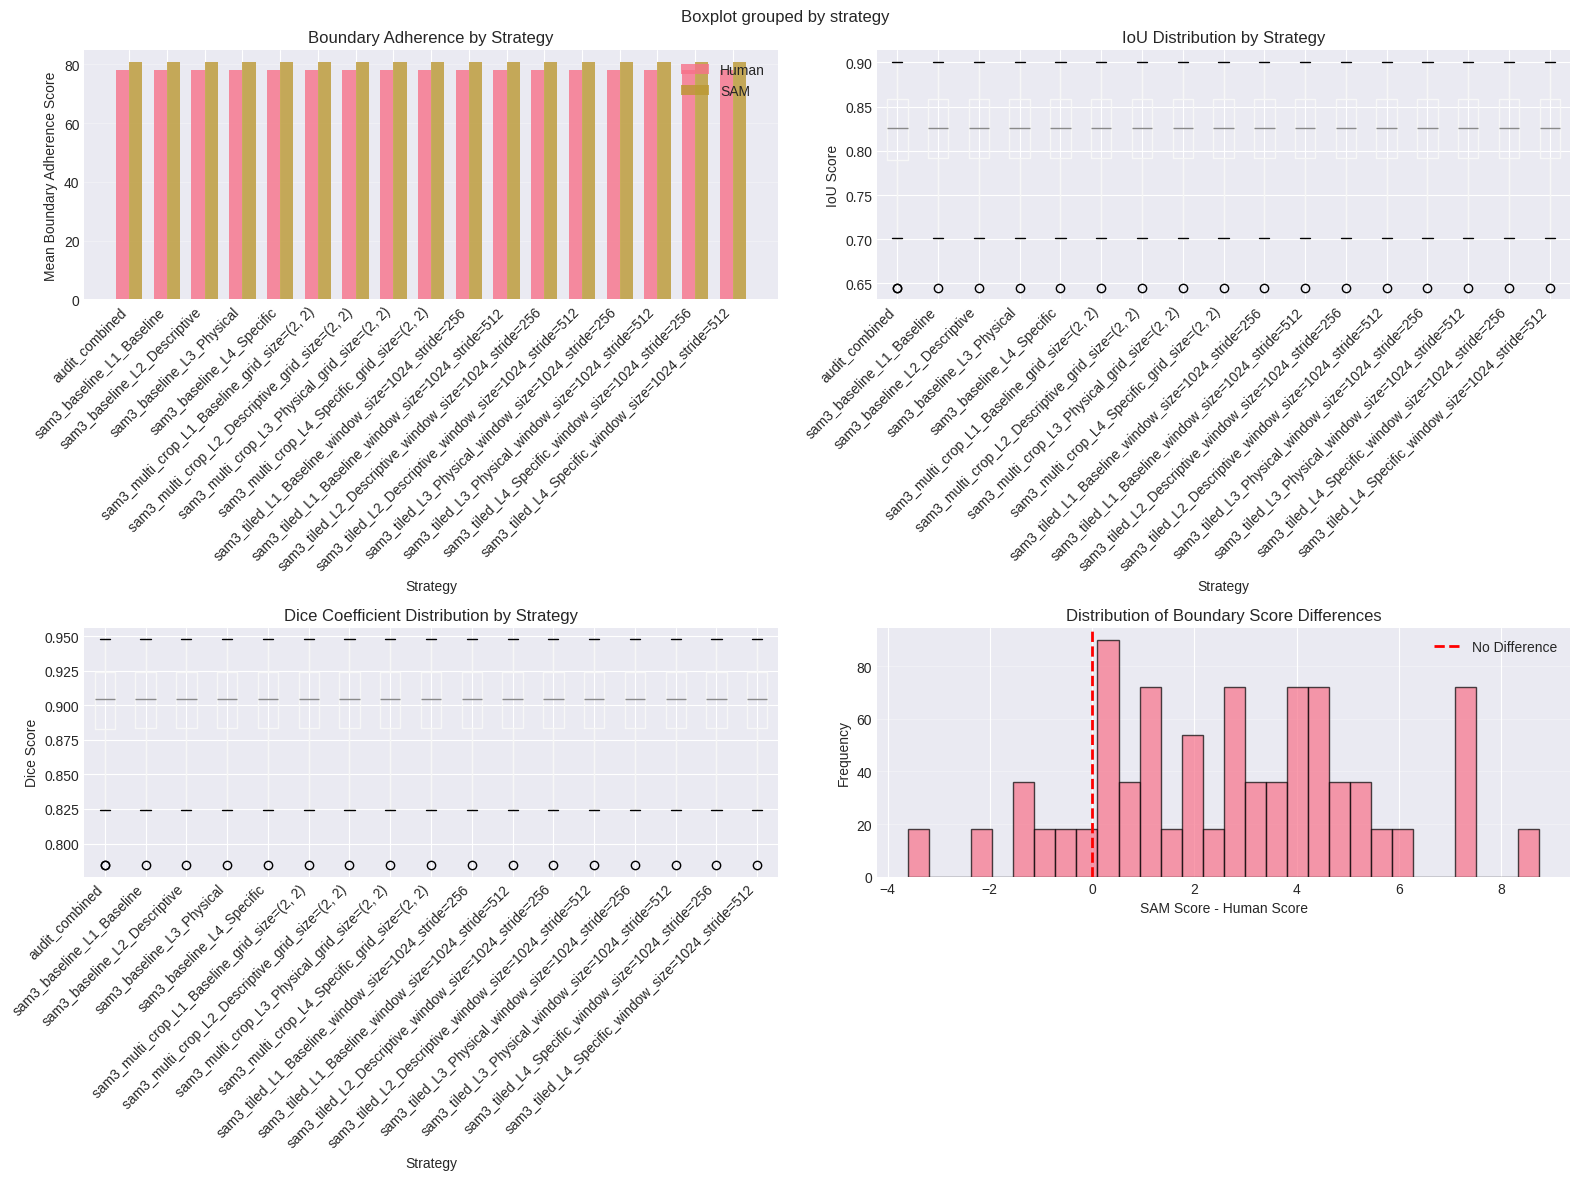

✓ Comparison visualizations generated


In [36]:
if not df_all.empty:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Audit Results: Boundary Adherence & Overlap Metrics', fontsize=16, fontweight='bold')
    
    # 1. Boundary Adherence Comparison
    ax = axes[0, 0]
    positions = range(len(df_all['strategy'].unique()))
    width = 0.35
    
    strategy_list = sorted(df_all['strategy'].unique())
    human_means = []
    sam_means = []
    
    for strategy in strategy_list:
        strategy_data = df_all[df_all['strategy'] == strategy]
        human_means.append(strategy_data['boundary_score_human'].mean())
        sam_means.append(strategy_data['boundary_score_sam'].mean())
    
    x_pos = np.arange(len(strategy_list))
    ax.bar(x_pos - width/2, human_means, width, label='Human', alpha=0.8)
    ax.bar(x_pos + width/2, sam_means, width, label='SAM', alpha=0.8)
    ax.set_xlabel('Strategy')
    ax.set_ylabel('Mean Boundary Adherence Score')
    ax.set_title('Boundary Adherence by Strategy')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(strategy_list, rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # 2. IoU Distribution
    ax = axes[0, 1]
    df_all.boxplot(column='iou', by='strategy', ax=ax)
    ax.set_xlabel('Strategy')
    ax.set_ylabel('IoU Score')
    ax.set_title('IoU Distribution by Strategy')
    plt.sca(ax)
    plt.xticks(rotation=45, ha='right')
    
    # 3. Dice Coefficient Distribution  
    ax = axes[1, 0]
    df_all.boxplot(column='dice', by='strategy', ax=ax)
    ax.set_xlabel('Strategy')
    ax.set_ylabel('Dice Score')
    ax.set_title('Dice Coefficient Distribution by Strategy')
    plt.sca(ax)
    plt.xticks(rotation=45, ha='right')
    
    # 4. Histogram: Boundary Score Differences
    ax = axes[1, 1]
    boundary_diff = df_all['boundary_score_sam'] - df_all['boundary_score_human']
    ax.hist(boundary_diff, bins=30, alpha=0.7, edgecolor='black')
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='No Difference')
    ax.set_xlabel('SAM Score - Human Score')
    ax.set_ylabel('Frequency')
    ax.set_title('Distribution of Boundary Score Differences')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Comparison visualizations generated")

### Detailed Strategy Comparison


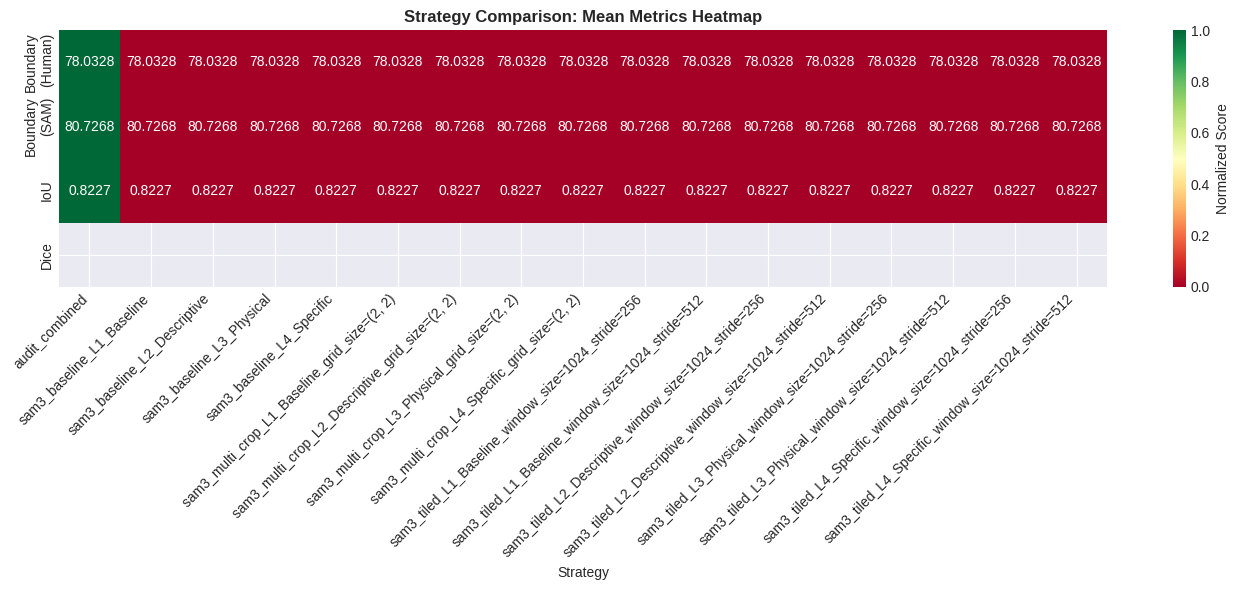

✓ Strategy comparison heatmap generated


In [37]:
if not df_all.empty:
    # Create a detailed comparison table
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Prepare data for heatmap
    strategies = sorted(df_all['strategy'].unique())
    metrics_to_plot = ['boundary_score_human', 'boundary_score_sam', 'iou', 'dice']
    metric_labels = ['Boundary\n(Human)', 'Boundary\n(SAM)', 'IoU', 'Dice']
    
    heatmap_data = []
    for strategy in strategies:
        strategy_data = df_all[df_all['strategy'] == strategy]
        row = [
            strategy_data['boundary_score_human'].mean(),
            strategy_data['boundary_score_sam'].mean(),
            strategy_data['iou'].mean(),
            strategy_data['dice'].mean(),
        ]
        heatmap_data.append(row)
    
    heatmap_array = np.array(heatmap_data)
    
    # Normalize for better visualization
    heatmap_normalized = (heatmap_array - heatmap_array.min(axis=0)) / (heatmap_array.max(axis=0) - heatmap_array.min(axis=0))
    
    sns.heatmap(
        heatmap_normalized.T,
        annot=heatmap_array.T,
        fmt='.4f',
        cmap='RdYlGn',
        xticklabels=strategies,
        yticklabels=metric_labels,
        cbar_kws={'label': 'Normalized Score'},
        ax=ax
    )
    ax.set_title('Strategy Comparison: Mean Metrics Heatmap', fontweight='bold', fontsize=12)
    ax.set_xlabel('Strategy')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    print("✓ Strategy comparison heatmap generated")

### Class-Level Analysis


STATISTICS BY CLASS
            n_samples  boundary_score_human_mean  boundary_score_human_std  \
class_name                                                                   
Pole              200                    78.0328                   17.5982   

            boundary_score_sam_mean  boundary_score_sam_std  iou_mean  \
class_name                                                              
Pole                        80.7268                 18.3322    0.8227   

            iou_std  dice_mean  dice_std  
class_name                                
Pole         0.0518     0.9018    0.0322  



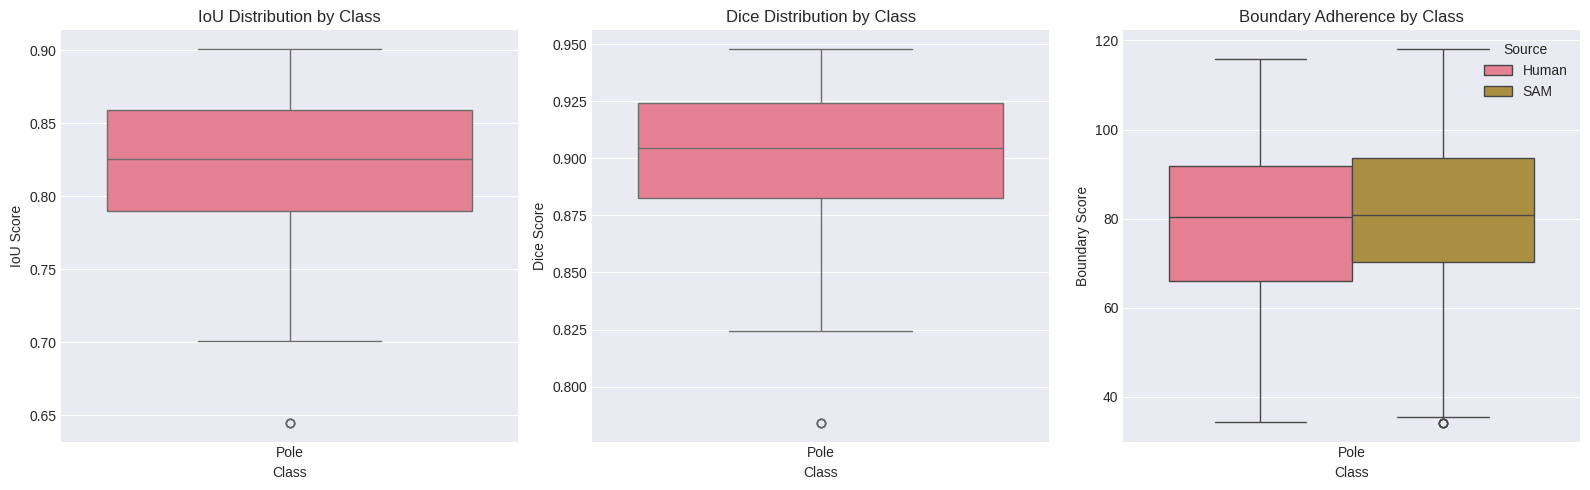

✓ Class-level visualizations generated


In [27]:
if not df_all.empty and 'class_id' in df_all.columns:
    # Class mapping from Cityscapes
    class_names = {
        17: 'Pole',
        18: 'Traffic Light',
        19: 'Traffic Sign',
    }
    
    # Filter for target classes
    target_classes = [17, 18, 19]
    df_classes = df_all[df_all['class_id'].isin(target_classes)].copy()
    df_classes['class_name'] = df_classes['class_id'].map(class_names)
    
    if not df_classes.empty:
        print("=" * 80)
        print("STATISTICS BY CLASS")
        print("=" * 80)
        
        class_stats = df_classes.groupby('class_name').agg({
            'image_id': 'count',
            'boundary_score_human': ['mean', 'std'],
            'boundary_score_sam': ['mean', 'std'],
            'iou': ['mean', 'std'],
            'dice': ['mean', 'std'],
        }).round(4)
        
        class_stats.columns = ['_'.join(col).strip() for col in class_stats.columns.values]
        class_stats = class_stats.rename(columns={'image_id_count': 'n_samples'})
        
        print(class_stats)
        print()
        
        # Visualize by class
        fig, axes = plt.subplots(1, 3, figsize=(16, 5))
        
        class_order = sorted(df_classes['class_name'].unique())
        
        # IoU by class
        sns.boxplot(data=df_classes, x='class_name', y='iou', order=class_order, ax=axes[0])
        axes[0].set_title('IoU Distribution by Class')
        axes[0].set_ylabel('IoU Score')
        axes[0].set_xlabel('Class')
        
        # Dice by class
        sns.boxplot(data=df_classes, x='class_name', y='dice', order=class_order, ax=axes[1])
        axes[1].set_title('Dice Distribution by Class')
        axes[1].set_ylabel('Dice Score')
        axes[1].set_xlabel('Class')
        
        # Boundary adherence by class
        df_classes_melted = df_classes[['class_name', 'boundary_score_human', 'boundary_score_sam']].melt(
            id_vars=['class_name'],
            var_name='Source',
            value_name='Boundary Score'
        )
        df_classes_melted['Source'] = df_classes_melted['Source'].map({
            'boundary_score_human': 'Human',
            'boundary_score_sam': 'SAM'
        })
        
        sns.boxplot(data=df_classes_melted, x='class_name', y='Boundary Score', hue='Source', ax=axes[2])
        axes[2].set_title('Boundary Adherence by Class')
        axes[2].set_ylabel('Boundary Score')
        axes[2].set_xlabel('Class')
        
        plt.tight_layout()
        plt.show()
        
        print("✓ Class-level visualizations generated")
    else:
        print("⚠ No target class data found")

## 4.5 Visual Analysis of Edge Cases

Visualize actual images with the largest score differences to understand where SAM predictions deviate most from human annotations.

TOP 6 CASES WITH LARGEST BOUNDARY SCORE DIFFERENCES
               image_id                     strategy  class_id  boundary_score_human  boundary_score_sam  boundary_diff      iou     dice
frankfurt_000000_004617               audit_combined        17              94.75643          103.488434       8.732004 0.808898 0.894355
frankfurt_000000_004617               audit_combined        17              94.75643          103.488434       8.732004 0.808898 0.894355
frankfurt_000000_004617    sam3_baseline_L1_Baseline        17              94.75643          103.488434       8.732004 0.808898 0.894355
frankfurt_000000_004617 sam3_baseline_L2_Descriptive        17              94.75643          103.488434       8.732004 0.808898 0.894355
frankfurt_000000_004617    sam3_baseline_L3_Physical        17              94.75643          103.488434       8.732004 0.808898 0.894355
frankfurt_000000_004617    sam3_baseline_L4_Specific        17              94.75643          103.488434       8.732004 

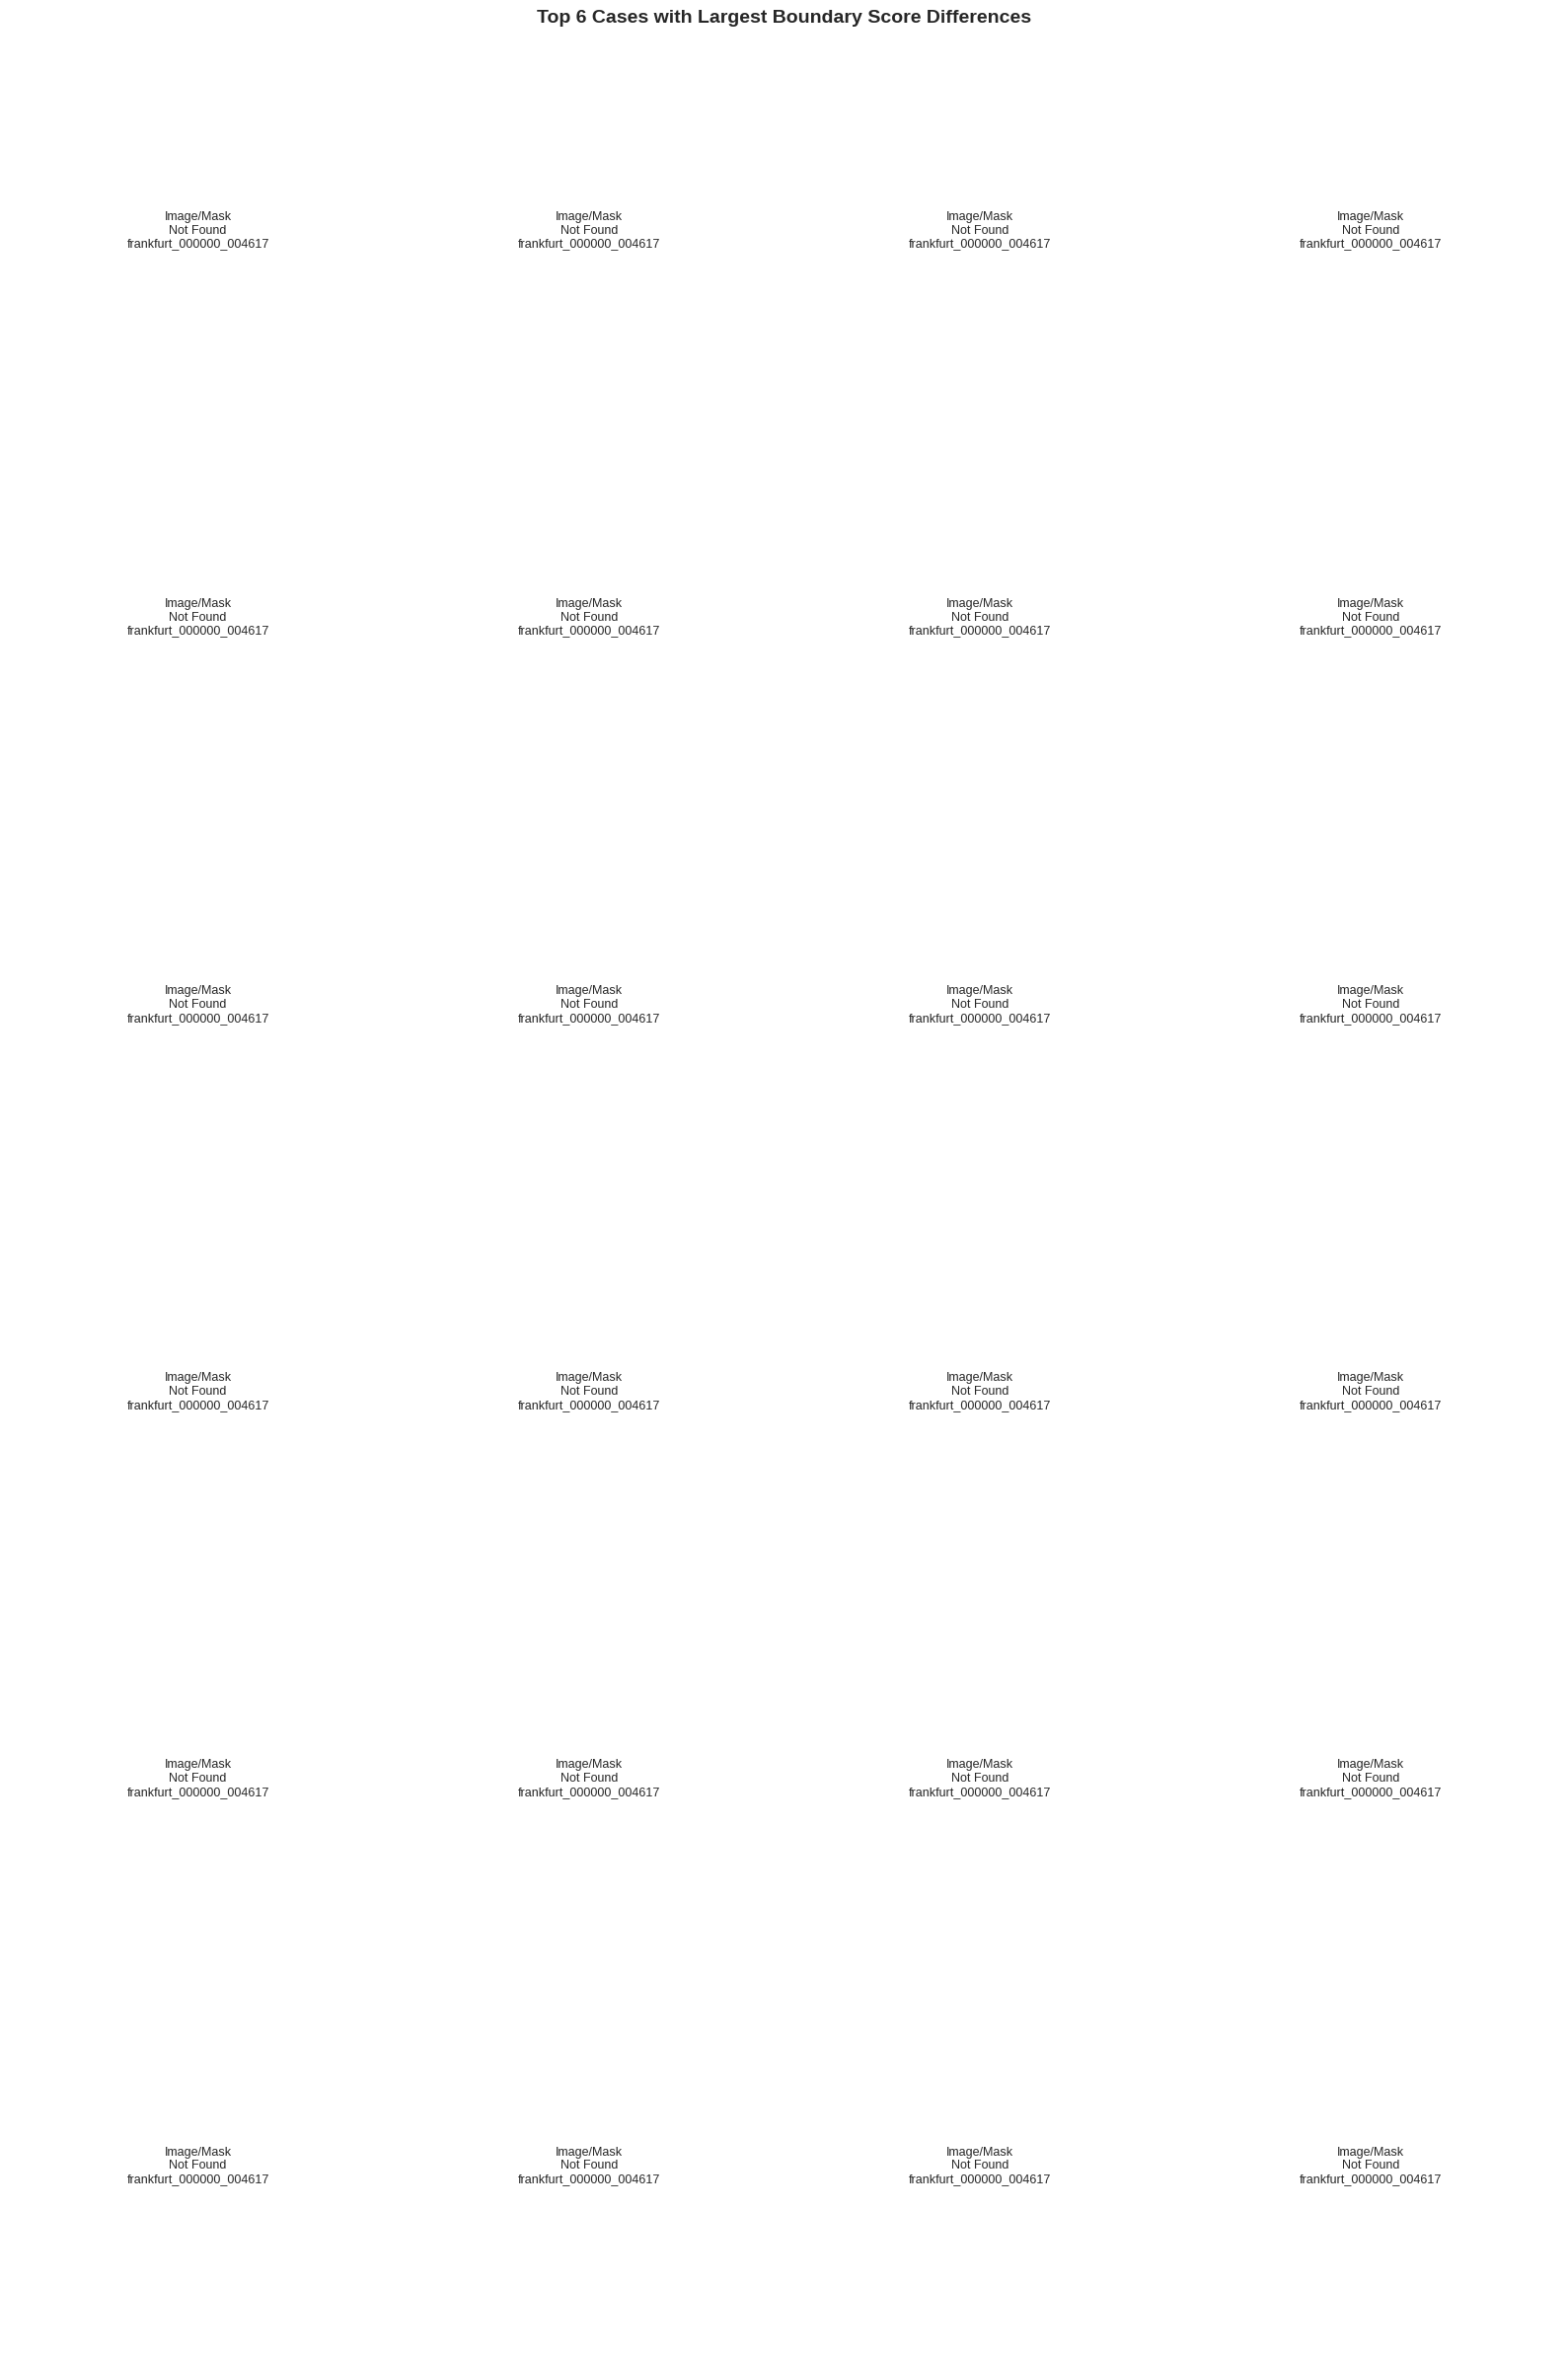

✓ Edge case visualizations generated


In [38]:
if not df_all.empty:
    from PIL import Image
    import matplotlib.patches as mpatches
    
    # Calculate boundary score difference
    df_all['boundary_diff'] = df_all['boundary_score_sam'] - df_all['boundary_score_human']
    df_all['boundary_diff_abs'] = df_all['boundary_diff'].abs()
    
    # Find top N cases with largest differences
    N_TOP = 6
    top_diff_cases = df_all.nlargest(N_TOP, 'boundary_diff_abs')
    
    print("=" * 80)
    print(f"TOP {N_TOP} CASES WITH LARGEST BOUNDARY SCORE DIFFERENCES")
    print("=" * 80)
    
    # Display available columns dynamically
    display_cols = ['image_id', 'strategy']
    if 'class_id' in df_all.columns:
        display_cols.append('class_id')
    if 'instance_id' in df_all.columns:
        display_cols.append('instance_id')
    display_cols.extend(['boundary_score_human', 'boundary_score_sam', 'boundary_diff', 'iou', 'dice'])
    
    print(top_diff_cases[display_cols].to_string(index=False))
    print()
    
    # Visualize the top cases
    fig, axes = plt.subplots(N_TOP, 4, figsize=(16, N_TOP * 4))
    
    for idx, (_, row) in enumerate(top_diff_cases.iterrows()):
        image_id = row['image_id']
        strategy = row['strategy']
        
        # Extract class_id and instance_id if available
        class_id = int(row['class_id']) if 'class_id' in row else None
        instance_id = int(row['instance_id']) if 'instance_id' in row else None
        
        # Load original image
        city_name = image_id.split('_')[0]
        img_path = DATA_ROOT / "leftImg8bit_trainvaltest" / "leftImg8bit" / "val" / city_name / f"{image_id}_leftImg8bit.png"

        # Load human annotation (ground truth)
        gt_instance_path = DATA_ROOT / "gtFine_trainvaltest" / "gtFine" / "val" / city_name / f"{image_id}_gtFine_instanceIds.png"
        
        # Find SAM mask - try different patterns
        strategy_dir = PROJECT_ROOT / "generated_masks" / strategy
        sam_mask_files = []
        
        if class_id is not None and instance_id is not None:
            mask_pattern = f"{image_id}_class{class_id}_inst{instance_id}_*.png"
            sam_mask_files = list(strategy_dir.glob(mask_pattern))
        
        if not sam_mask_files:
            # Try broader pattern
            mask_pattern = f"{image_id}_*.png"
            sam_mask_files = list(strategy_dir.glob(mask_pattern))
            if sam_mask_files:
                sam_mask_files = [sam_mask_files[0]]  # Take first match
        
        if img_path.exists() and sam_mask_files:
            # Load images
            img = np.array(Image.open(img_path))
            sam_mask = np.array(Image.open(sam_mask_files[0]))
            
            # Create binary SAM mask if needed
            if len(sam_mask.shape) > 2:
                sam_mask = sam_mask[:, :, 0]
            sam_mask_binary = (sam_mask > 127).astype(np.uint8) * 255
            
            # Try to load human mask
            human_mask = None
            if gt_instance_path.exists() and instance_id is not None:
                gt_instance = np.array(Image.open(gt_instance_path))
                human_mask = (gt_instance == instance_id).astype(np.uint8) * 255
            
            # Plot original image
            ax = axes[idx, 0] if N_TOP > 1 else axes[0]
            ax.imshow(img)
            title = f"Original Image\n{image_id[:30]}"
            if class_id is not None:
                title += f"\nClass: {class_id}"
            ax.set_title(title, fontsize=9)
            ax.axis('off')
            
            # Plot human annotation (if available)
            ax = axes[idx, 1] if N_TOP > 1 else axes[1]
            ax.imshow(img)
            if human_mask is not None:
                ax.imshow(human_mask, alpha=0.5, cmap='Greens')
                ax.set_title(f"Human Annotation\nScore: {row['boundary_score_human']:.4f}", fontsize=9)
            else:
                ax.set_title(f"Human Annotation\nNot Available", fontsize=9)
            ax.axis('off')
            
            # Plot SAM prediction
            ax = axes[idx, 2] if N_TOP > 1 else axes[2]
            ax.imshow(img)
            ax.imshow(sam_mask_binary, alpha=0.5, cmap='Reds')
            ax.set_title(f"SAM Prediction\nScore: {row['boundary_score_sam']:.4f}", fontsize=9)
            ax.axis('off')
            
            # Plot overlay
            ax = axes[idx, 3] if N_TOP > 1 else axes[3]
            if human_mask is not None:
                overlay = np.zeros((*human_mask.shape, 3), dtype=np.uint8)
                overlay[human_mask > 0] = [0, 255, 0]  # Green for human
                overlay[sam_mask_binary > 0] = [255, 0, 0]  # Red for SAM
                overlay[(human_mask > 0) & (sam_mask_binary > 0)] = [255, 255, 0]  # Yellow for overlap
                
                ax.imshow(img)
                ax.imshow(overlay, alpha=0.5)
                ax.set_title(f"Overlay\nDiff: {row['boundary_diff']:.4f} | IoU: {row['iou']:.3f}", fontsize=9)
                
                # Add legend on first row
                if idx == 0:
                    green_patch = mpatches.Patch(color='green', label='Human Only')
                    red_patch = mpatches.Patch(color='red', label='SAM Only')
                    yellow_patch = mpatches.Patch(color='yellow', label='Overlap')
                    ax.legend(handles=[green_patch, red_patch, yellow_patch], 
                             loc='upper right', fontsize=8)
            else:
                ax.imshow(img)
                ax.imshow(sam_mask_binary, alpha=0.5, cmap='Reds')
                ax.set_title(f"SAM Only\nIoU: {row['iou']:.3f}", fontsize=9)
            ax.axis('off')
        else:
            for col in range(4):
                ax = axes[idx, col] if N_TOP > 1 else axes[col]
                ax.text(0.5, 0.5, f'Image/Mask\nNot Found\n{image_id[:30]}', 
                       ha='center', va='center', fontsize=9)
                ax.axis('off')
    
    plt.suptitle(f'Top {N_TOP} Cases with Largest Boundary Score Differences', 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    print("✓ Edge case visualizations generated")
else:
    print("⚠ No data to visualize")

## 4.6 Additional Research Visualizations

Advanced analytical visualizations to explore relationships between metrics and identify patterns.

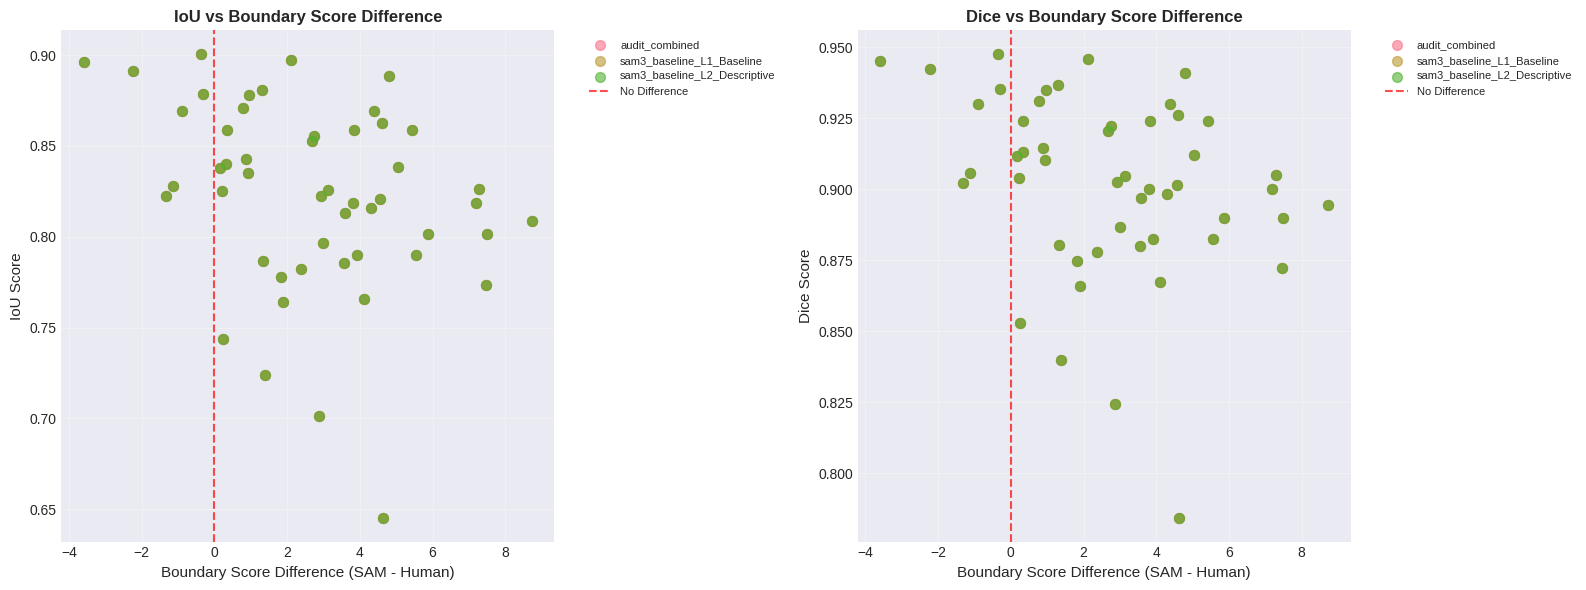

✓ Scatter plot visualizations generated


In [29]:
if not df_all.empty:
    # Scatter plot: IoU vs Boundary Score Difference
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: IoU vs Boundary Difference
    ax = axes[0]
    for strategy in sorted(df_all['strategy'].unique()):
        strategy_data = df_all[df_all['strategy'] == strategy]
        ax.scatter(strategy_data['boundary_diff'], strategy_data['iou'], 
                  alpha=0.6, s=50, label=strategy)
    
    ax.axvline(x=0, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='No Difference')
    ax.set_xlabel('Boundary Score Difference (SAM - Human)', fontsize=11)
    ax.set_ylabel('IoU Score', fontsize=11)
    ax.set_title('IoU vs Boundary Score Difference', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    # Plot 2: Dice vs Boundary Difference  
    ax = axes[1]
    for strategy in sorted(df_all['strategy'].unique()):
        strategy_data = df_all[df_all['strategy'] == strategy]
        ax.scatter(strategy_data['boundary_diff'], strategy_data['dice'], 
                  alpha=0.6, s=50, label=strategy)
    
    ax.axvline(x=0, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='No Difference')
    ax.set_xlabel('Boundary Score Difference (SAM - Human)', fontsize=11)
    ax.set_ylabel('Dice Score', fontsize=11)
    ax.set_title('Dice vs Boundary Score Difference', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Scatter plot visualizations generated")
else:
    print("⚠ No data to visualize")

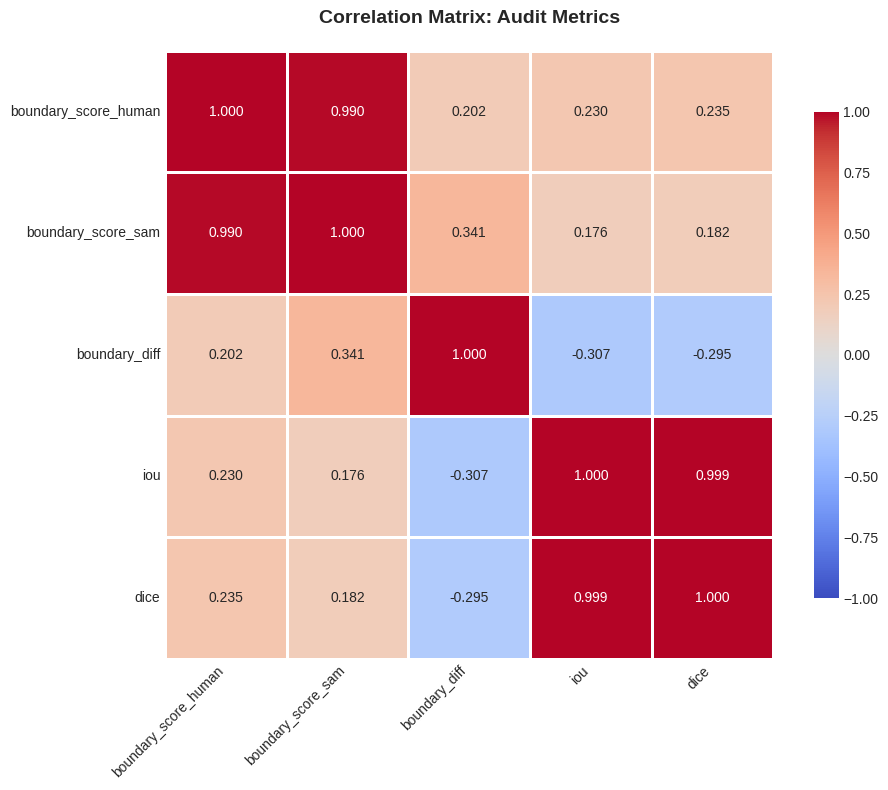

CORRELATION INSIGHTS

Strongest Positive Correlations:
             metric1            metric2  correlation
                 iou               dice     0.998903
boundary_score_human boundary_score_sam     0.989639
  boundary_score_sam      boundary_diff     0.340939
boundary_score_human               dice     0.234805
boundary_score_human                iou     0.230460

Strongest Negative Correlations:
             metric1       metric2  correlation
boundary_score_human boundary_diff     0.202432
  boundary_score_sam          dice     0.182114
  boundary_score_sam           iou     0.176191
       boundary_diff          dice    -0.295262
       boundary_diff           iou    -0.307218

✓ Correlation analysis completed


In [19]:
if not df_all.empty:
    # Correlation Matrix for Key Metrics
    fig, ax = plt.subplots(figsize=(10, 8))
    
    metrics_for_correlation = ['boundary_score_human', 'boundary_score_sam', 
                                'boundary_diff', 'iou', 'dice']
    
    # Check if all metrics exist
    available_metrics = [m for m in metrics_for_correlation if m in df_all.columns]
    
    correlation_matrix = df_all[available_metrics].corr()
    
    sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
                center=0, vmin=-1, vmax=1, square=True, 
                linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
    
    ax.set_title('Correlation Matrix: Audit Metrics', fontsize=14, fontweight='bold', pad=20)
    
    # Rotate labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    print("=" * 80)
    print("CORRELATION INSIGHTS")
    print("=" * 80)
    print("\nStrongest Positive Correlations:")
    
    # Find top correlations (excluding diagonal)
    corr_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_pairs.append({
                'metric1': correlation_matrix.columns[i],
                'metric2': correlation_matrix.columns[j],
                'correlation': correlation_matrix.iloc[i, j]
            })
    
    df_corr = pd.DataFrame(corr_pairs).sort_values('correlation', ascending=False)
    print(df_corr.head(5).to_string(index=False))
    
    print("\nStrongest Negative Correlations:")
    print(df_corr.tail(5).to_string(index=False))
    print()
    
    print("✓ Correlation analysis completed")
else:
    print("⚠ No data to visualize")

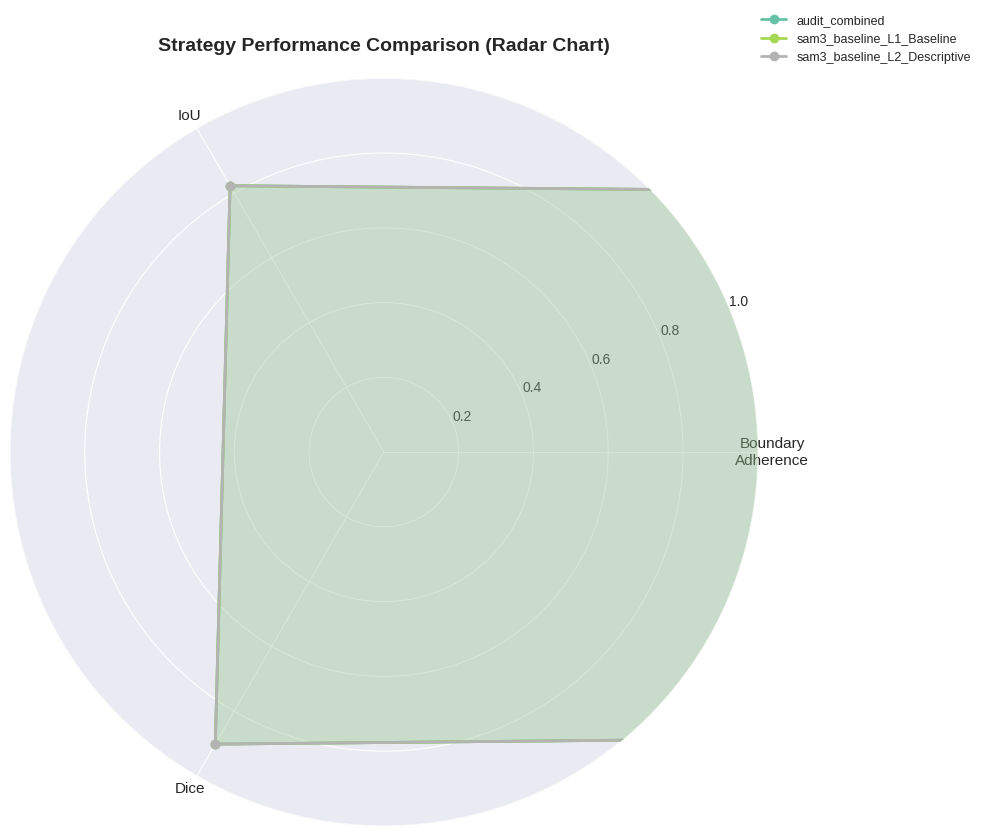

✓ Radar chart visualization generated


In [20]:
if not df_all.empty and len(df_all['strategy'].unique()) > 1:
    # Radar Chart for Strategy Comparison
    from math import pi
    
    # Select top strategies by sample count
    strategy_counts = df_all['strategy'].value_counts()
    top_strategies = strategy_counts.head(5).index.tolist()
    
    # Metrics to compare (normalized to 0-1 range)
    metrics = ['boundary_score_sam', 'iou', 'dice']
    metric_labels = ['Boundary\nAdherence', 'IoU', 'Dice']
    
    # Calculate mean scores for each strategy
    strategy_scores = {}
    for strategy in top_strategies:
        strategy_data = df_all[df_all['strategy'] == strategy]
        scores = [strategy_data[m].mean() for m in metrics]
        strategy_scores[strategy] = scores
    
    # Number of variables
    num_vars = len(metrics)
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]
    
    # Create radar chart
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    colors = plt.cm.Set2(np.linspace(0, 1, len(top_strategies)))
    
    for idx, (strategy, scores) in enumerate(strategy_scores.items()):
        scores += scores[:1]  # Complete the circle
        ax.plot(angles, scores, 'o-', linewidth=2, label=strategy, color=colors[idx])
        ax.fill(angles, scores, alpha=0.15, color=colors[idx])
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metric_labels, size=11)
    ax.set_ylim(0, 1)
    ax.set_title('Strategy Performance Comparison (Radar Chart)', 
                 size=14, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=9)
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Radar chart visualization generated")
else:
    print("⚠ Insufficient strategies for radar chart")

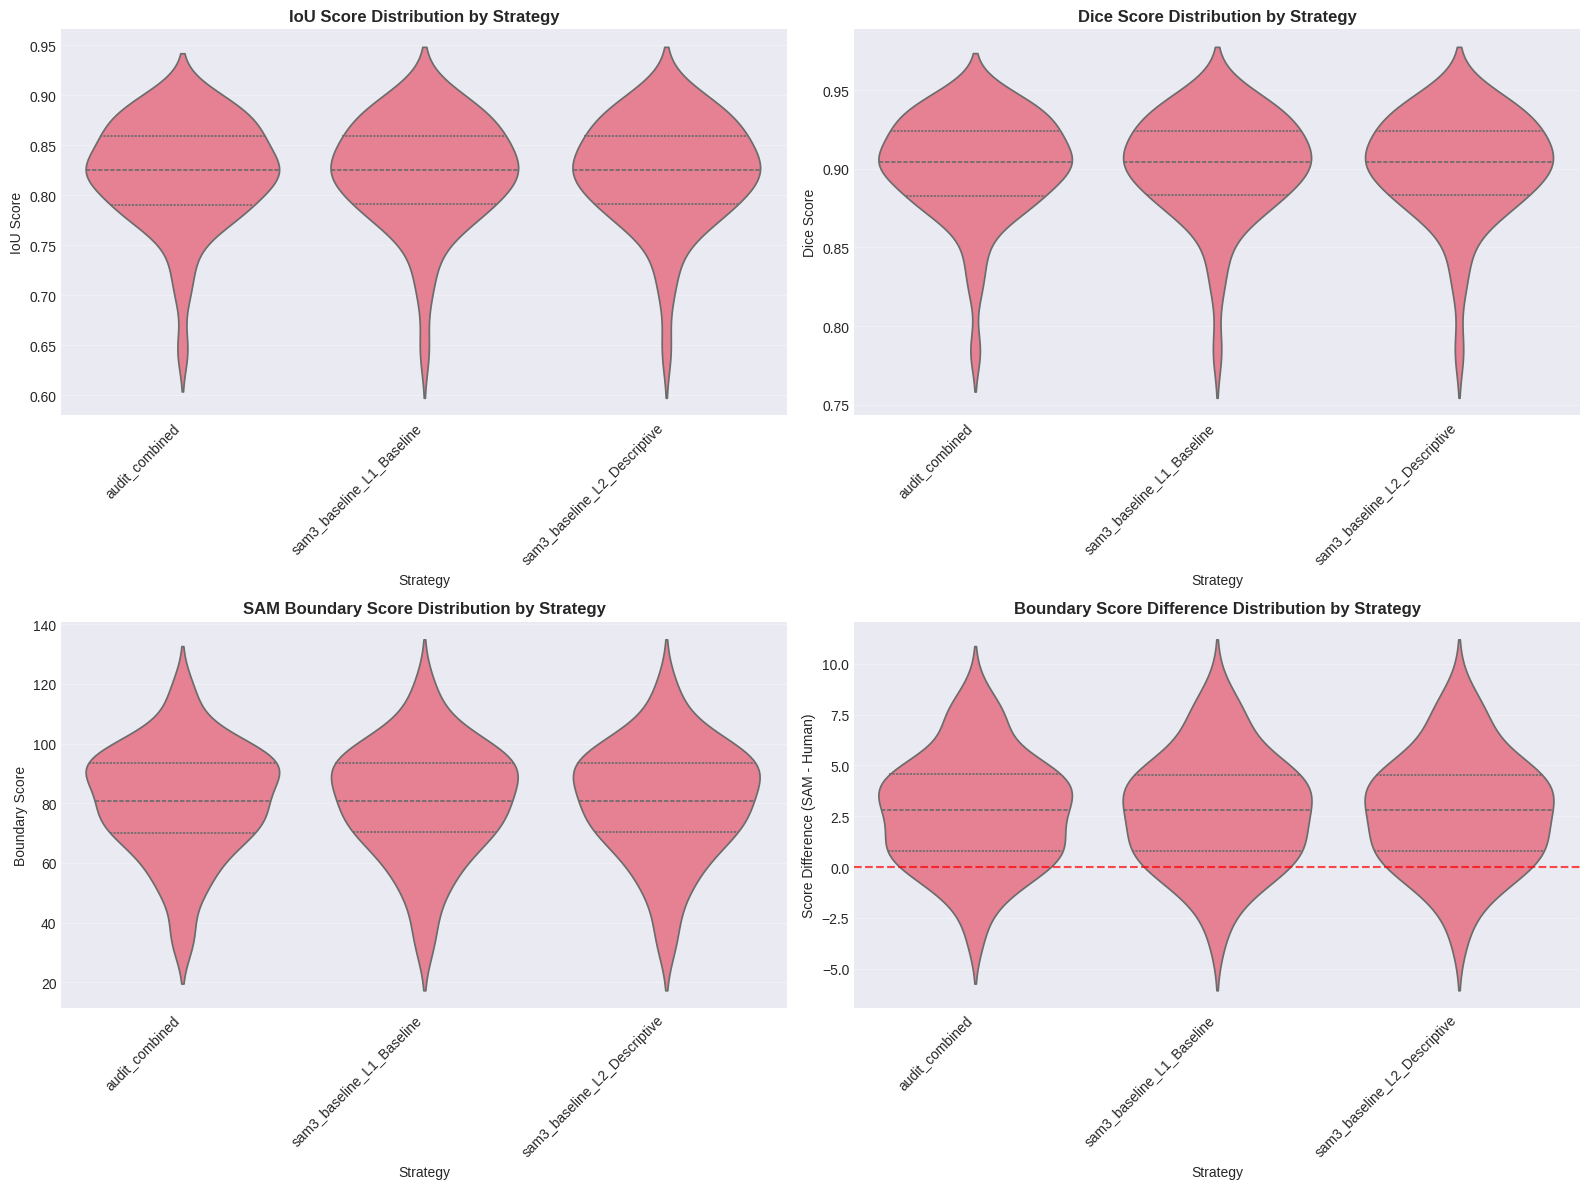

✓ Violin plot distributions generated


In [21]:
if not df_all.empty:
    # Violin plots for metric distributions by strategy
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # IoU distribution
    ax = axes[0, 0]
    sns.violinplot(data=df_all, x='strategy', y='iou', ax=ax, inner='quartile')
    ax.set_title('IoU Score Distribution by Strategy', fontsize=12, fontweight='bold')
    ax.set_xlabel('Strategy', fontsize=10)
    ax.set_ylabel('IoU Score', fontsize=10)
    plt.sca(ax)
    plt.xticks(rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)
    
    # Dice distribution
    ax = axes[0, 1]
    sns.violinplot(data=df_all, x='strategy', y='dice', ax=ax, inner='quartile')
    ax.set_title('Dice Score Distribution by Strategy', fontsize=12, fontweight='bold')
    ax.set_xlabel('Strategy', fontsize=10)
    ax.set_ylabel('Dice Score', fontsize=10)
    plt.sca(ax)
    plt.xticks(rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)
    
    # Boundary score (SAM) distribution
    ax = axes[1, 0]
    sns.violinplot(data=df_all, x='strategy', y='boundary_score_sam', ax=ax, inner='quartile')
    ax.set_title('SAM Boundary Score Distribution by Strategy', fontsize=12, fontweight='bold')
    ax.set_xlabel('Strategy', fontsize=10)
    ax.set_ylabel('Boundary Score', fontsize=10)
    plt.sca(ax)
    plt.xticks(rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)
    
    # Boundary difference distribution
    ax = axes[1, 1]
    sns.violinplot(data=df_all, x='strategy', y='boundary_diff', ax=ax, inner='quartile')
    ax.axhline(y=0, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    ax.set_title('Boundary Score Difference Distribution by Strategy', fontsize=12, fontweight='bold')
    ax.set_xlabel('Strategy', fontsize=10)
    ax.set_ylabel('Score Difference (SAM - Human)', fontsize=10)
    plt.sca(ax)
    plt.xticks(rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Violin plot distributions generated")
else:
    print("⚠ No data to visualize")

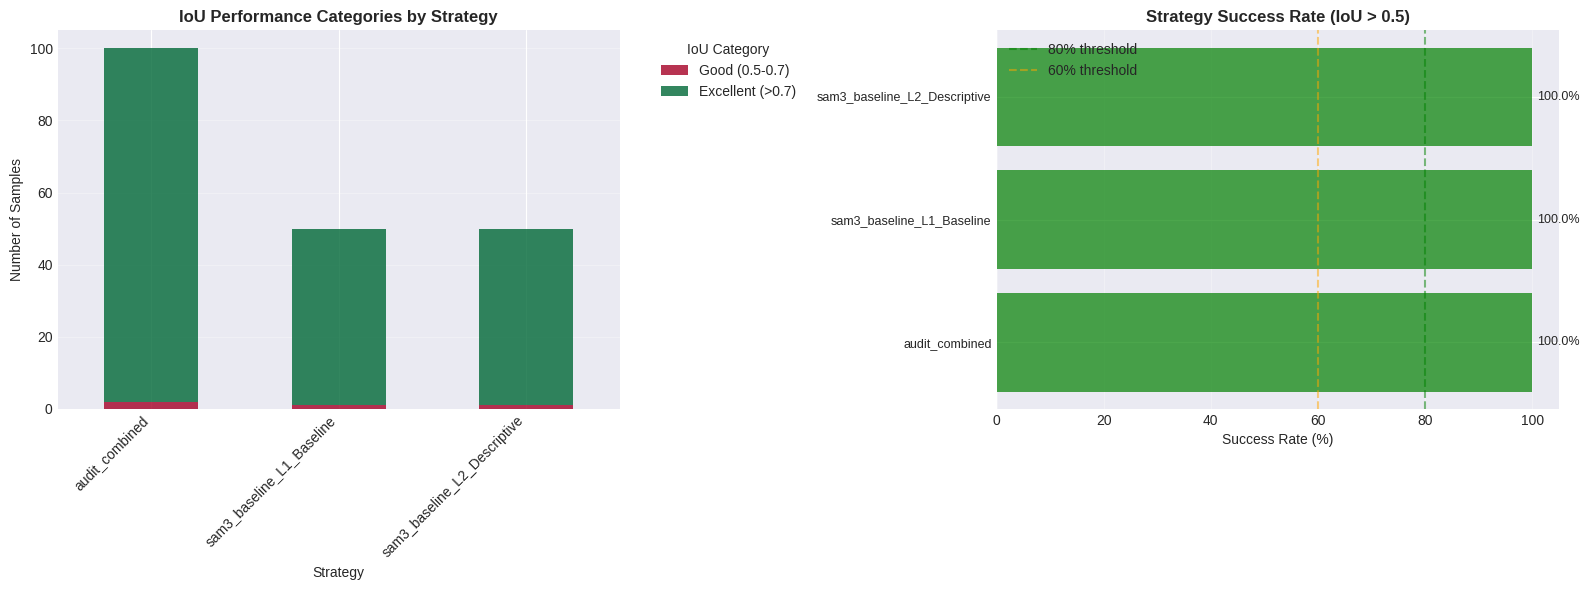

PERFORMANCE CATEGORY SUMMARY

IoU Category Distribution (All Strategies):
iou_category
Poor (<0.3)           0
Fair (0.3-0.5)        0
Good (0.5-0.7)        4
Excellent (>0.7)    196
Name: count, dtype: int64

Overall Success Rate (IoU > 0.5): 100.00%
Overall Excellent Rate (IoU > 0.7): 98.00%

✓ Performance categorization analysis completed


In [22]:
if not df_all.empty:
    # Performance categorization and analysis
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Categorize samples by IoU performance
    df_all['iou_category'] = pd.cut(df_all['iou'], 
                                     bins=[0, 0.3, 0.5, 0.7, 1.0],
                                     labels=['Poor (<0.3)', 'Fair (0.3-0.5)', 
                                            'Good (0.5-0.7)', 'Excellent (>0.7)'])
    
    # Plot 1: IoU category distribution by strategy
    ax = axes[0]
    category_counts = df_all.groupby(['strategy', 'iou_category']).size().unstack(fill_value=0)
    category_counts.plot(kind='bar', stacked=True, ax=ax, 
                         colormap='RdYlGn', alpha=0.8)
    ax.set_title('IoU Performance Categories by Strategy', fontsize=12, fontweight='bold')
    ax.set_xlabel('Strategy', fontsize=10)
    ax.set_ylabel('Number of Samples', fontsize=10)
    ax.legend(title='IoU Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.sca(ax)
    plt.xticks(rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)
    
    # Plot 2: Strategy success rate (IoU > 0.5)
    ax = axes[1]
    success_rates = []
    strategy_names = []
    
    for strategy in sorted(df_all['strategy'].unique()):
        strategy_data = df_all[df_all['strategy'] == strategy]
        success_rate = (strategy_data['iou'] > 0.5).sum() / len(strategy_data) * 100
        success_rates.append(success_rate)
        strategy_names.append(strategy)
    
    colors = ['green' if rate >= 80 else 'orange' if rate >= 60 else 'red' 
              for rate in success_rates]
    
    bars = ax.barh(range(len(strategy_names)), success_rates, color=colors, alpha=0.7)
    ax.set_yticks(range(len(strategy_names)))
    ax.set_yticklabels(strategy_names, fontsize=9)
    ax.set_xlabel('Success Rate (%)', fontsize=10)
    ax.set_title('Strategy Success Rate (IoU > 0.5)', fontsize=12, fontweight='bold')
    ax.axvline(x=80, color='green', linestyle='--', alpha=0.5, label='80% threshold')
    ax.axvline(x=60, color='orange', linestyle='--', alpha=0.5, label='60% threshold')
    ax.legend()
    ax.grid(axis='x', alpha=0.3)
    
    # Add percentage labels on bars
    for i, (bar, rate) in enumerate(zip(bars, success_rates)):
        ax.text(rate + 1, i, f'{rate:.1f}%', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("=" * 80)
    print("PERFORMANCE CATEGORY SUMMARY")
    print("=" * 80)
    print("\nIoU Category Distribution (All Strategies):")
    print(df_all['iou_category'].value_counts().sort_index())
    print(f"\nOverall Success Rate (IoU > 0.5): {(df_all['iou'] > 0.5).sum() / len(df_all) * 100:.2f}%")
    print(f"Overall Excellent Rate (IoU > 0.7): {(df_all['iou'] > 0.7).sum() / len(df_all) * 100:.2f}%")
    print()
    
    print("✓ Performance categorization analysis completed")
else:
    print("⚠ No data to visualize")

## 5. Export Analysis Report

Save comprehensive analysis results to CSV and JSON formats for external reporting.


In [8]:
if not df_all.empty:
    # Create summary report
    report = {
        'metadata': {
            'timestamp': pd.Timestamp.now().isoformat(),
            'total_samples': len(df_all),
            'unique_strategies': df_all['strategy'].nunique(),
            'strategies': sorted(df_all['strategy'].unique().tolist()),
        },
        'overall_metrics': {
            'boundary_score_human': {
                'mean': float(df_all['boundary_score_human'].mean()),
                'std': float(df_all['boundary_score_human'].std()),
                'min': float(df_all['boundary_score_human'].min()),
                'max': float(df_all['boundary_score_human'].max()),
            },
            'boundary_score_sam': {
                'mean': float(df_all['boundary_score_sam'].mean()),
                'std': float(df_all['boundary_score_sam'].std()),
                'min': float(df_all['boundary_score_sam'].min()),
                'max': float(df_all['boundary_score_sam'].max()),
            },
            'iou': {
                'mean': float(df_all['iou'].mean()),
                'std': float(df_all['iou'].std()),
                'min': float(df_all['iou'].min()),
                'max': float(df_all['iou'].max()),
            },
            'dice': {
                'mean': float(df_all['dice'].mean()),
                'std': float(df_all['dice'].std()),
                'min': float(df_all['dice'].min()),
                'max': float(df_all['dice'].max()),
            },
        },
        'strategy_metrics': {}
    }
    
    # Add per-strategy metrics
    for strategy in sorted(df_all['strategy'].unique()):
        strategy_data = df_all[df_all['strategy'] == strategy]
        report['strategy_metrics'][strategy] = {
            'n_samples': len(strategy_data),
            'boundary_score_human_mean': float(strategy_data['boundary_score_human'].mean()),
            'boundary_score_sam_mean': float(strategy_data['boundary_score_sam'].mean()),
            'iou_mean': float(strategy_data['iou'].mean()),
            'dice_mean': float(strategy_data['dice'].mean()),
        }
    
    # Save as JSON
    report_json_path = AUDIT_RESULTS_DIR / 'audit_analysis_report.json'
    with open(report_json_path, 'w') as f:
        json.dump(report, f, indent=2)
    print(f"✓ Report saved to {report_json_path}")
    
    # Save summary statistics as CSV
    summary_stats = []
    for strategy in sorted(df_all['strategy'].unique()):
        strategy_data = df_all[df_all['strategy'] == strategy]
        summary_stats.append({
            'strategy': strategy,
            'n_samples': len(strategy_data),
            'boundary_human_mean': strategy_data['boundary_score_human'].mean(),
            'boundary_human_std': strategy_data['boundary_score_human'].std(),
            'boundary_sam_mean': strategy_data['boundary_score_sam'].mean(),
            'boundary_sam_std': strategy_data['boundary_score_sam'].std(),
            'iou_mean': strategy_data['iou'].mean(),
            'iou_std': strategy_data['iou'].std(),
            'dice_mean': strategy_data['dice'].mean(),
            'dice_std': strategy_data['dice'].std(),
        })
    
    df_summary = pd.DataFrame(summary_stats)
    summary_csv_path = AUDIT_RESULTS_DIR / 'audit_summary_statistics.csv'
    df_summary.to_csv(summary_csv_path, index=False)
    print(f"✓ Summary statistics saved to {summary_csv_path}")
    
    # Also save a comprehensive CSV with all data
    comprehensive_csv_path = AUDIT_RESULTS_DIR / 'audit_combined_results.csv'
    df_all.to_csv(comprehensive_csv_path, index=False)
    print(f"✓ Combined results saved to {comprehensive_csv_path}")
    
    print(f"\n✓ All analysis files saved to: {AUDIT_RESULTS_DIR}")
else:
    print("⚠ No data to export")

✓ Report saved to /home/griffing52/programming/research/urban-segmentation/outputs/audit_results/audit_analysis_report.json
✓ Summary statistics saved to /home/griffing52/programming/research/urban-segmentation/outputs/audit_results/audit_summary_statistics.csv
✓ Combined results saved to /home/griffing52/programming/research/urban-segmentation/outputs/audit_results/audit_combined_results.csv

✓ All analysis files saved to: /home/griffing52/programming/research/urban-segmentation/outputs/audit_results


## 6. Notes & Future Audit Additions

### Design for Extensibility

This notebook is designed to automatically incorporate new audit results:

1. **Automatic Discovery**: The `discover_audit_results()` function scans the `audit_results/` directory and loads all `*_results.csv` files
2. **Dynamic Strategy Parsing**: Strategy names are parsed to extract method, prompt level, and parameters
3. **Flexible Aggregation**: All metrics are aggregated regardless of how many strategies have been audited
4. **New Result Types**: The notebook gracefully handles new audit results without modification

### Running New Audits

To add new audit results:

1. Run the auditor with new strategies:
   ```bash
   python scripts/run_audit.py --strategies baseline multi_crop tiled --prompts L1_Baseline L2_Descriptive L3_Physical L4_Specific
   ```

2. Re-run this notebook - it will automatically discover and analyze the new results

### Output Files

- `audit_combined_results.csv` - All samples with all metrics
- `audit_summary_statistics.csv` - Summary statistics per strategy
- `audit_analysis_report.json` - Complete JSON report with metadata

### Metrics Explained

- **Boundary Adherence Score**: Mean gradient magnitude at mask boundary (higher = sharper edges)
- **IoU (Intersection over Union)**: Overlap metric, range [0, 1]
- **Dice Coefficient**: Harmonic mean of precision/recall, range [0, 1]

### Next Steps

1. Run audits for additional strategies/prompt levels
2. Compare with different SAM model versions
3. Analyze specific failure cases
4. Generate paper-ready figures
